In [98]:
import numpy as np
import matplotlib.pyplot as plt
from lgdo import lh5, VectorOfVectors, WaveformTable, Table, ArrayOfEqualSizedArrays, Array
from numba import guvectorize
from dspeed.utils import numba_defaults_kwargs as nb_kwargs

In [112]:
%matplotlib ipympl

In [213]:
# this processor will inject a gumbel distribution into the waveform
@guvectorize(
    [
        "void(float32[:], float32, float32, float32,float32[:])",
        "void(float64[:], float64, float64, float64,float64[:])",
    ],
    "(n),(),(),()->(n)",
    **nb_kwargs,
)

def gumbel_inject(wf_in, a, t0, beta, wf_out):

    wf_out[:] = np.nan

    if (
        np.isnan(wf_in).any()
        or np.isnan(a)
        or np.isnan(t0)
        or np.isnan(beta)
    ):
        return
    wf_out[:] = wf_in[:]

    start = t0 # I have defined the distribution to essentially start at 2 sigma below the centroid
    mu = t0 + (2 * beta)
    end = mu + 8 * beta
    if start < 0:
        start = 0
    if end > len(wf_in):
        end = len(wf_in)
    
    for i in range(start, end):
        z = (i-mu)/beta
        wf_out[i] +=  (a/beta) * np.exp(-(z + np.exp(-z)))


In [152]:
from math import exp

In [153]:
@guvectorize(
    [
        "void(float32[:], float32, float32, float32, float32, float32[:])",
        "void(float64[:], float64, float64,float64,float64,float64[:])",
    ],
    "(n),(),(),(), ()->(n)",
    **nb_kwargs,
)
def inject_exp_pulse(
    wf_in: np.ndarray, t0: int, rt: float, a: float, decay: float, wf_out: np.ndarray
) -> None:
    """Inject exponential pulse into existing waveform to simulate pileup.

    Parameters
    ----------
    wf_in
        the input waveform.
    t0
        the position of the injected waveform.
    rt
        the rise time of the injected waveform.
    a
        the amplitude of the injected waveform.
    decay
        the exponential decay constant of the injected waveform.
    wf_out
        the output waveform.
    """

    wf_out[:] = np.nan

    if (
        np.isnan(wf_in).any()
        or np.isnan(rt)
        or np.isnan(t0)
        or np.isnan(a)
        or np.isnan(decay)
    ):
        return

    wf_out[:] = wf_in[:]
    for t in range(len(wf_out)):
        if t >= t0 and t <= t0 + rt:
            wf_out[t] += a * exp((t - t0 - rt) / (rt)) * exp(-(1 / decay) * (t - t0))
        elif t > t0 + rt:
            wf_out[t] += a * exp(-(1 / decay) * (t - t0))

In [313]:
@guvectorize(
    [
        "void(float32[:], float32, float32, float32, float32, float32[:])",
        "void(float64[:], float64, float64,float64,float64,float64[:])",
    ],
    "(n),(),(),(), ()->(n)",
    **nb_kwargs,
)
def inject_gompertz_pulse(
    wf_in: np.ndarray, t0: int, rt: float, a: float, decay: float, wf_out: np.ndarray
) -> None:
    """Inject exponential pulse into existing waveform to simulate pileup.

    Parameters
    ----------
    wf_in
        the input waveform.
    t0
        the position of the injected waveform.
    rt
        the rise time of the injected waveform.
    a
        the amplitude of the injected waveform.
    decay
        the exponential decay constant of the injected waveform.
    wf_out
        the output waveform.
    """

    wf_out[:] = np.nan

    if (
        np.isnan(wf_in).any()
        or np.isnan(rt)
        or np.isnan(t0)
        or np.isnan(a)
        or np.isnan(decay)
    ):
        return

    wf_out[:] = wf_in[:]
    for t in range(len(wf_out)):
        wf_out[t] = wf_out[t] + a * exp((t0 + rt / 2) * exp(-rt*t)) * exp(-(1 / decay) * (t - t0))

In [118]:
# we'll just use basic white noise as the basis of our waveforms, this is slightly different to the 
# waveform data we have where the lower frequencies are higher
mean = 0
std = 20
num_samples = 1000
wf_len = 32
samples = np.random.normal(mean, std, size=(num_samples, wf_len))


In [119]:
# shift samples to mean value 2000 (roughly corresponding to data
mean = 2000
std = 20
samples += np.random.normal(mean, std, size=(num_samples, 1))


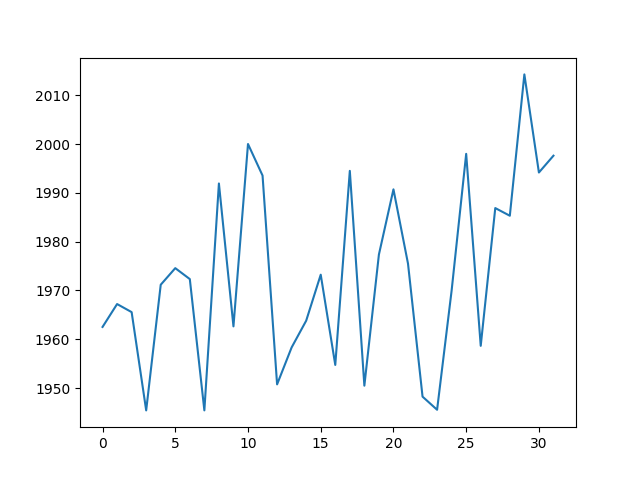

In [120]:
plt.figure()
plt.plot(samples[0,:])
plt.show()

In [142]:
# initialise the output object
wf_gumbel = np.zeros_like(samples)
wf_exp = np.zeros_like(samples)

In [157]:
# fix amplitude and width, vary t0 using uniform distribution
amplitude = 1000
width = 1
t0 = np.random.uniform(12,14,num_samples)

In [144]:
for i in range(num_samples):
    gumbel_inject(samples[i,:], amplitude, t0[i], width, wf_gumbel[i,:])

In [141]:
from dspeed.processors import inject_exp_pulse

In [176]:
amplitude = 400
rt = 2
decay = 3

In [177]:
for i in range(num_samples):
    inject_exp_pulse(samples[i,:], t0[i], rt, amplitude, decay, wf_exp[i,:])

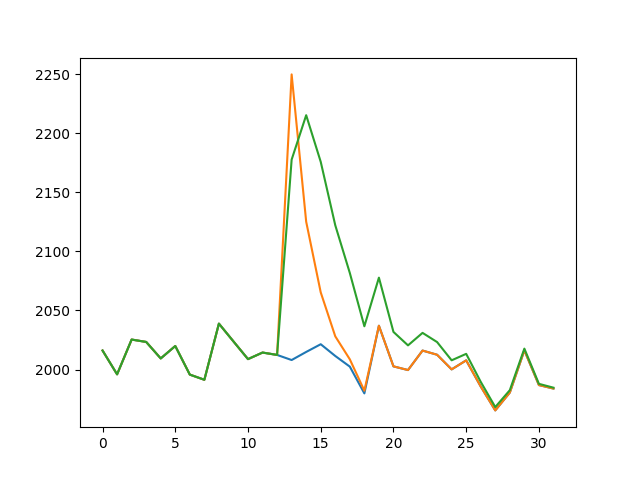

In [178]:
plt.figure()
plt.plot(samples[1,:])
plt.plot(wf_gumbel[1,:])
plt.plot(wf_exp[1,:])
plt.show()

In [136]:
sim_values =  ArrayOfEqualSizedArrays(nda=wf_gumbel,dtype=np.uint16)

In [137]:
sim_wfs = WaveformTable(values= sim_values, dt=4.8, dt_units="ns",t0=0, t0_units="ns")

In [138]:
table = Table({"waveform":sim_wfs})


In [128]:
from pathlib import Path

In [129]:
file_path = Path("../sim_data/raw/sim_wfs_white_noise.lh5")
file_path.parent.mkdir(parents=True, exist_ok=True)
lh5.write(table,
          name="raw",
          lh5_file=file_path
         )

In [139]:
# this processor will inject a gumbel distribution into the waveform

def random_normal_build(seed, mu, sigma):
    ran = np.random.default_rng(seed)

    @guvectorize(
    [
        "void(float32[:])",
        "void(float64[:])",
    ],
        "(n)",
        **nb_kwargs,
    )

    def random_normal(w_out):
        w_out = ran.normal(mu, sigma, w_out.shape)
    return random_normal

In [140]:
ran = random_normal_build(1, 0, 1)

NumbaNotImplementedError: Failed in nopython mode pipeline (step: native lowering)
<numba.core.base.OverloadSelector object at 0x15a824490>, (NumPyRandomGeneratorType,)
During: lowering "$2load_deref.0 = freevar(ran: Generator(PCG64))" at /var/folders/ch/dytr8n99541626ftf95bnnq40000gn/T/ipykernel_33014/3966424394.py (16)

In [ ]:
ran(

In [235]:
from dspeed.processors import inject_sig_pulse

In [196]:
xs = np.zeros(2000)

In [304]:
wf_test_g = np.zeros_like(xs)
wf_test_exp = np.zeros_like(xs)
wf_test_sig = np.zeros_like(xs)
wf_test_sig2 = np.zeros_like(xs)

array([2.09988249e-06, 2.13709407e-06, 2.17496506e-06, ...,
       3.13582758e-02, 3.12688085e-02, 3.11795966e-02])

<function matplotlib.pyplot.show(block=None)>

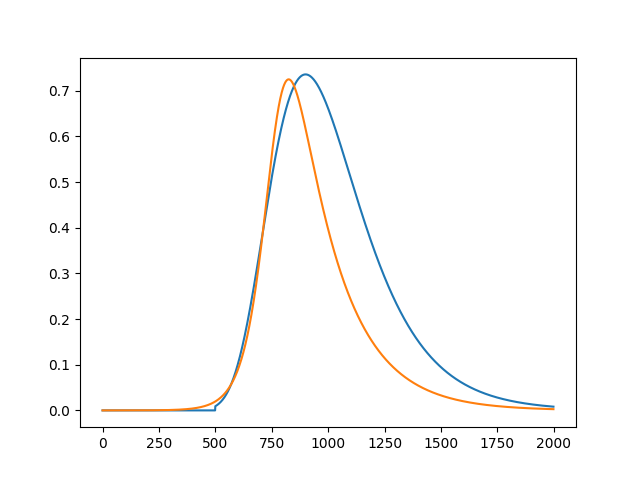

In [315]:
gumbel_inject(xs, 400, 500, 200, wf_test_g)
inject_exp_pulse(xs, 500, 100, 1, 200, wf_test_exp)
inject_sig_pulse(xs, 320, 900, 12, 200, wf_test_sig)
#inject_gompertz_pulse(xs, 320, 900, 12, 200, wf_test_sig2)
plt.figure()
plt.plot(wf_test_g)
#plt.plot(wf_test_exp)
plt.plot(wf_test_sig)
#plt.plot(wf_test_sig2)

plt.show

In [316]:
indexes = np.arange(0,100, 5) 
indexes

array([ 0,  5, 10, ..., 85, 90, 95])

In [ ]:
flat_t0 = np.floor(t0)
shifts_list = flat_t0 - t0_start  # what is t0 start?
# this will need to be more general will need 
# to perform a first shift to fixed position i.e. subtract t0 first
wf_extended = np.zeros(wf_len)
counts = np.zeros(wf_len)
for i, wf in enumerate(wf_gumbel): # this should be easier to do on the array level
    shift = int(shifts_list[i])
    for j, value in enumerate(wf):
            index = j-shift
            #print(index)
            # print(shift, j, index)
            wf_extended[index]+= value
            counts[index]+= 1

plt.figure()
plt.plot(wf_extended/counts)
plt.show()